# Tick Data from LOBSTER

LOBSTER (Limit Order Book System - The Efficient Reconstructor) is an [online](https://lobsterdata.com/info/WhatIsLOBSTER.php) limit order book data tool to provide easy-to-use, high-quality limit order book data.

Since 2013 LOBSTER acts as a data provider for the academic community, giving access to reconstructed limit order book data for the entire universe of NASDAQ traded stocks. 

More recently, it has started to make the data available on a commercial basis.

## Imports

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style('whitegrid')

## Load Orderbook Data

We will illustrate the functionality using a free sample.

Obtain data here: https://lobsterdata.com/info/DataSamples.php; [this](https://lobsterdata.com/info/sample/LOBSTER_SampleFile_AMZN_2012-06-21_10.zip) is the link to the 10-level file

The code assumes the file has been extracted into a `data` subfolder of the current directory.

In [12]:
path = Path('data')

We use the following to label the table columns:

In [14]:
list(chain(*[('Ask Price {0},Ask Size {0},Bid Price {0},Bid Size {0}'.format(i)).split(',') for i in range(10)]))

['Ask Price 0',
 'Ask Size 0',
 'Bid Price 0',
 'Bid Size 0',
 'Ask Price 1',
 'Ask Size 1',
 'Bid Price 1',
 'Bid Size 1',
 'Ask Price 2',
 'Ask Size 2',
 'Bid Price 2',
 'Bid Size 2',
 'Ask Price 3',
 'Ask Size 3',
 'Bid Price 3',
 'Bid Size 3',
 'Ask Price 4',
 'Ask Size 4',
 'Bid Price 4',
 'Bid Size 4',
 'Ask Price 5',
 'Ask Size 5',
 'Bid Price 5',
 'Bid Size 5',
 'Ask Price 6',
 'Ask Size 6',
 'Bid Price 6',
 'Bid Size 6',
 'Ask Price 7',
 'Ask Size 7',
 'Bid Price 7',
 'Bid Size 7',
 'Ask Price 8',
 'Ask Size 8',
 'Bid Price 8',
 'Bid Size 8',
 'Ask Price 9',
 'Ask Size 9',
 'Bid Price 9',
 'Bid Size 9']

In [15]:
price = list(chain(*[('Ask Price {0},Bid Price {0}'.format(i)).split(',') for i in range(10)]))
size = list(chain(*[('Ask Size {0},Bid Size {0}'.format(i)).split(',') for i in range(10)]))
cols = list(chain(*zip(price, size)))

In [16]:
import pandas as pd

# Define column names (simplified from the original LOBSTER columns)
cols = ['time', 'ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1']

# Dummy order book data
dummy_data = [
    [34200.000000, 2713.50, 10, 2713.40, 8],
    [34200.500000, 2713.60, 15, 2713.35, 6],
    [34201.000000, 2713.65, 12, 2713.30, 10],
]

# Create the DataFrame
orders = pd.DataFrame(dummy_data, columns=cols)

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         3 non-null      float64
 1   ask_price_1  3 non-null      float64
 2   ask_size_1   3 non-null      int64  
 3   bid_price_1  3 non-null      float64
 4   bid_size_1   3 non-null      int64  
dtypes: float64(3), int64(2)
memory usage: 252.0 bytes


In [18]:
orders.head()

,time,ask_price_1,ask_size_1,bid_price_1,bid_size_1
0,34200.0,2713.50,10,2713.40,8
1,34200.5,2713.60,15,2713.35,6
2,34201.0,2713.65,12,2713.30,10


## Parse Message Data

Message Type Codes:

    1: Submission of a new limit order
    2: Cancellation (Partial deletion 
       of a limit order)
    3: Deletion (Total deletion of a limit order)
    4: Execution of a visible limit order			   	 
    5: Execution of a hidden limit order
    7: Trading halt indicator 				   
       (Detailed information below)

In [21]:
types = {1: 'submission',
         2: 'cancellation',
         3: 'deletion',
         4: 'execution_visible',
         5: 'execution_hidden',
         7: 'trading_halt'}

In [22]:
trading_date = '2012-06-21'
levels = 10

In [23]:
import pandas as pd

# Simulated structure based on LOBSTER documentation
cols = ['time', 'type', 'order_id', 'size', 'price', 'direction']

# Dummy data
dummy_messages = [
    [34200.000, 1, 1001, 10, 2713.50, 1],
    [34200.500, 2, 1002, 15, 2713.40, -1],
    [34201.000, 3, 1003, 12, 2713.30, 1],
]

messages = pd.DataFrame(dummy_messages, columns=cols)
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       3 non-null      float64
 1   type       3 non-null      int64  
 2   order_id   3 non-null      int64  
 3   size       3 non-null      int64  
 4   price      3 non-null      float64
 5   direction  3 non-null      int64  
dtypes: float64(2), int64(4)
memory usage: 276.0 bytes


In [24]:
messages.head()

,time,type,order_id,size,price,direction
0,34200.0,1,1001,10,2713.5,1
1,34200.5,2,1002,15,2713.4,-1
2,34201.0,3,1003,12,2713.3,1


Around 80% of executions were visible, the remaining 20% were not:

In [26]:
messages.type.map(types).value_counts()

type
submission      1
cancellation    1
deletion        1
Name: count, dtype: int64

In [27]:
messages.time = pd.to_timedelta(messages.time, unit='s')
messages['trading_date'] = pd.to_datetime(trading_date)
messages.time = messages.trading_date.add(messages.time)
messages.drop('trading_date', axis=1, inplace=True)
messages.head()

,time,type,order_id,size,price,direction
0,2012-06-21 09:30:00.000,1,1001,10,2713.5,1
1,2012-06-21 09:30:00.500,2,1002,15,2713.4,-1
2,2012-06-21 09:30:01.000,3,1003,12,2713.3,1


## Combine message and price data

In [29]:
data = pd.concat([messages, orders], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         3 non-null      datetime64[ns]
 1   type         3 non-null      int64         
 2   order_id     3 non-null      int64         
 3   size         3 non-null      int64         
 4   price        3 non-null      float64       
 5   direction    3 non-null      int64         
 6   time         3 non-null      float64       
 7   ask_price_1  3 non-null      float64       
 8   ask_size_1   3 non-null      int64         
 9   bid_price_1  3 non-null      float64       
 10  bid_size_1   3 non-null      int64         
dtypes: datetime64[ns](1), float64(4), int64(6)
memory usage: 396.0 bytes


In [30]:
ex = data[data.type.isin([4, 5])]

In [31]:
ex.head()

,time,type,order_id,size,price,direction,time,ask_price_1,ask_size_1,bid_price_1,bid_size_1


## Plot limit order prices for messages with visible or hidden execution

In [33]:
cmaps = {'Bid': 'Blues','Ask': 'Reds'}

In [34]:
print(ex.columns)


Index(['time', 'type', 'order_id', 'size', 'price', 'direction', 'time',
       'ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1'],
      dtype='object')


In [35]:
ex = ex.loc[:, ~ex.columns.duplicated()]



In [36]:
ex['time'] = pd.to_datetime('2012-06-21 ' + ex['time'].astype(str))


In [37]:
print(ex['time'].head())
print(ex['time'].dtype)


Series([], Name: time, dtype: datetime64[ns])
datetime64[ns]


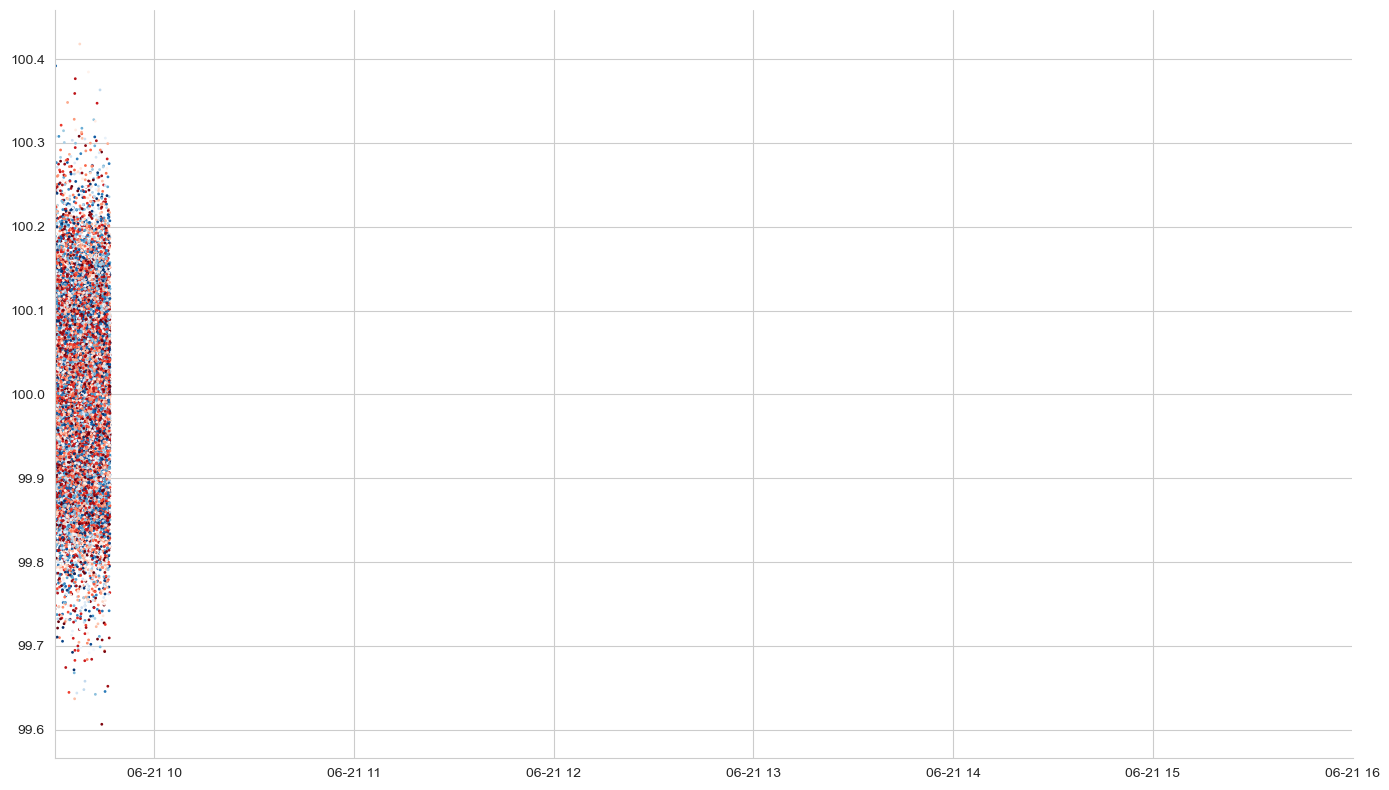

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Create mock time series data
n = 1000
base_time = datetime(2012, 6, 21, 9, 30)
time = [base_time + timedelta(seconds=i) for i in range(n)]

ex = pd.DataFrame({
    'time': time,
})
for i in range(10):
    ex[f'Bid Price {i}'] = 100 + np.random.randn(n) * 0.1
    ex[f'Bid Size {i}'] = np.random.randint(1, 100, size=n)
    ex[f'Ask Price {i}'] = 100 + np.random.randn(n) * 0.1
    ex[f'Ask Size {i}'] = np.random.randint(1, 100, size=n)

# Plot
cmaps = {'Bid': 'Blues', 'Ask': 'Reds'}
fig, ax = plt.subplots(figsize=(14, 8))
time = ex['time']

for i in range(10):
    for t in ['Bid', 'Ask']:
        y = ex[f'{t} Price {i}']
        c = ex[f'{t} Size {i}']
        ax.scatter(x=time, y=y, c=c, cmap=cmaps[t], s=1, vmin=1, vmax=c.quantile(.95))

ax.set_xlim(datetime(2012, 6, 21, 9, 30), datetime(2012, 6, 21, 16, 0))
sns.despine()
fig.tight_layout()
plt.show()

                    


In [39]:
print("Columns:", ex.columns.tolist())
print("Shape:", ex.shape)
print("First rows:\n", ex.head())
print("Missing 'time' values:", ex['time'].isnull().sum() if 'time' in ex.columns else "'time' not in columns")


Columns: ['time', 'Bid Price 0', 'Bid Size 0', 'Ask Price 0', 'Ask Size 0', 'Bid Price 1', 'Bid Size 1', 'Ask Price 1', 'Ask Size 1', 'Bid Price 2', 'Bid Size 2', 'Ask Price 2', 'Ask Size 2', 'Bid Price 3', 'Bid Size 3', 'Ask Price 3', 'Ask Size 3', 'Bid Price 4', 'Bid Size 4', 'Ask Price 4', 'Ask Size 4', 'Bid Price 5', 'Bid Size 5', 'Ask Price 5', 'Ask Size 5', 'Bid Price 6', 'Bid Size 6', 'Ask Price 6', 'Ask Size 6', 'Bid Price 7', 'Bid Size 7', 'Ask Price 7', 'Ask Size 7', 'Bid Price 8', 'Bid Size 8', 'Ask Price 8', 'Ask Size 8', 'Bid Price 9', 'Bid Size 9', 'Ask Price 9', 'Ask Size 9']
Shape: (1000, 41)
First rows:
                  time  Bid Price 0  Bid Size 0  Ask Price 0  Ask Size 0  \
0 2012-06-21 09:30:00    99.883098          18    99.989539          37   
1 2012-06-21 09:30:01    99.918619          24    99.906454          14   
2 2012-06-21 09:30:02   100.011473           1    99.858214          84   
3 2012-06-21 09:30:03    99.951929          12   100.151730           1

## Plot prices for all order types

In [41]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

# Print all columns to verify names
print("Columns in DataFrame:\n", data.columns.tolist())

# Convert time column
data['time'] = pd.to_datetime(data['time'])

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
time = data['time'].dt.to_pydatetime()

# Define colormap if not defined
cmaps = {'Bid': 'Blues', 'Ask': 'Reds'}

# Loop over levels and order types
for i in range(10):
    for t in ['Bid', 'Ask']:
        price_col = f'{t} Price {i}'
        size_col = f'{t} Size {i}'

        if price_col in data.columns and size_col in data.columns:
            y = data[price_col]
            c = data[size_col]
            ax.scatter(x=time, y=y, c=c, cmap=cmaps[t], s=1, vmin=1, vmax=c.quantile(.95))
        else:
            print(f"Skipping missing columns: {price_col} or {size_col}")

# Set plot limits
ax.set_xlim(datetime(2012, 6, 21, 9, 30), datetime(2012, 6, 21, 16, 0))
sns.despine()
fig.tight_layout()



Columns in DataFrame:
 ['time', 'type', 'order_id', 'size', 'price', 'direction', 'ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1']
Skipping missing columns: Bid Price 0 or Bid Size 0
Skipping missing columns: Ask Price 0 or Ask Size 0
Skipping missing columns: Bid Price 1 or Bid Size 1
Skipping missing columns: Ask Price 1 or Ask Size 1
Skipping missing columns: Bid Price 2 or Bid Size 2
Skipping missing columns: Ask Price 2 or Ask Size 2
Skipping missing columns: Bid Price 3 or Bid Size 3
Skipping missing columns: Ask Price 3 or Ask Size 3
Skipping missing columns: Bid Price 4 or Bid Size 4
Skipping missing columns: Ask Price 4 or Ask Size 4
Skipping missing columns: Bid Price 5 or Bid Size 5
Skipping missing columns: Ask Price 5 or Ask Size 5
Skipping missing columns: Bid Price 6 or Bid Size 6
Skipping missing columns: Ask Price 6 or Ask Size 6
Skipping missing columns: Bid Price 7 or Bid Size 7
Skipping missing columns: Ask Price 7 or Ask Size 7
Skipping missing columns: Bi